## https://www.linkedin.com/in/amitfallach/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from joblib import Parallel, delayed

##### The file dailykos contains data on 3,430 news articles or blogs published in Kos Daily.
##### These articles were published in 2004 and led to the United States presidential election. The leading candidates were the president Incumbent George W. Bush (Republican) and John Kerry (Democrat). Foreign policy was a dominant issue in the elections, and especially.The invasion of Iraq in 2003 Each of the variables in the data set is a word that appeared in at least 50 different articles (1,545 words in total). The array of words is trimmed according to some of the existing techniques in text analysis (punctuation removed and stop words removed). For each document, the variable values are the number of times the word appeared in the document.

##### We will use different clustering methods to learn about the algorithms and how they work and try to draw conclusions

In [3]:
data= pd.read_csv('dailykos.csv')
data.head()

,Document,abandon,abc,ability,abortion,absolute,abstain,abu,abuse,accept,...,yeah,year,yesterday,york,youll,young,youre,youve,zogby,zone
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,1,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0


##### 2 unusual things should be noted, the first is that the "document" column is a built-in index column and in order not to create confusion in the division into clusters we will remove it from the file. In addition, it can be seen that all the data are positive and have a common standard, so there is no need to perform scaling.

In [3]:
data = data.drop('Document', axis=1)

## K-means

##### function that implements the K means algorithm in different divisions and shows a comparison of the quality of the division according to SSE & silhouette score in addition to the graph of the elbow method.

##### We will emphasize that because it is known that the values in the data frame are natural numbers and about the same norm (they all represent the amount of words in the article) we will not need scaling.

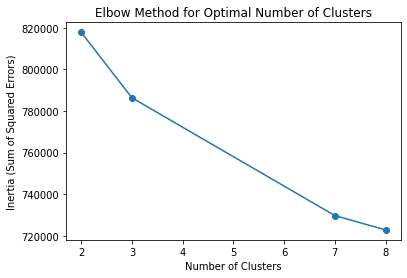

,Clusters,SSE,Silhouette,Sample Count,Min Count,Max Count
0,2,817799.896869,0.251754,0 3092 1 338 dtype: int64,338,3092
1,3,786329.814240,0.232192,1 2471 0 628 2 331 dtype: int64,331,2471
2,7,729793.941628,0.144815,1 1866 6 404 5 362 2 329 3 ...,53,1866
3,8,722874.901422,0.140831,7 1809 3 364 4 328 0 328 6 ...,41,1809


In [4]:
def cluster_and_evaluate(data, cluster_range=[2, 3, 7, 8]):
    
    results_df = pd.DataFrame(columns=['Clusters', 'SSE', 'Silhouette', 'Sample Count', 'Min Count', 'Max Count'])
    elbow_df = pd.DataFrame(columns=['Clusters', 'Inertia'])

    for num_clusters in cluster_range:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10).fit(data)
        labels = kmeans.labels_
        sample_count = pd.Series(labels).value_counts()

        # Calculate SSE (Sum of Squared Errors)
        sse = kmeans.inertia_
        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, labels)
        
        results_df = pd.concat([results_df, pd.DataFrame({'Clusters': [num_clusters], 'SSE': [sse], 'Silhouette': [silhouette_avg], 'Sample Count': [sample_count], 'Min Count': [sample_count.min()], 'Max Count': [sample_count.max()]})], ignore_index=True)
        elbow_df = pd.concat([elbow_df, pd.DataFrame({'Clusters': [num_clusters], 'Inertia': [sse]})], ignore_index=True)

    # Plotting the Elbow Method
    plt.plot(elbow_df['Clusters'], elbow_df['Inertia'], marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia (Sum of Squared Errors)')
    plt.show()

    return results_df

results = cluster_and_evaluate(data)
results

##### It can be seen that the SSE values are high and the silhouette is very low, in addition, it is not possible to unequivocally decide from the graph on an optimal division into clusters, therefore we will use scaled inertia.

##### Mathematical and theoretical explanation:
##### <blockquote>https://towardsdatascience.com/an-approach-for-choosing-number-of-clusters-for-k-means-c28e614ecb2c</blockquote>

In [5]:
def kMeansRes(scaled_data, k, alpha_k):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

In [6]:
def chooseBestKforKMeans(scaled_data, k_range, alpha_k=0.02):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k, alpha_k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns=['k', 'Scaled Inertia']).set_index('k')
    return results

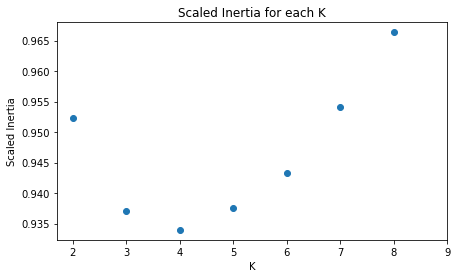

,Clusters,SSE,Scaled Inertia,Silhouette,Sample Count,Min Count,Max Count
0,2,817799.896869,0.952254,0.251754,0 3092 1 338 dtype: int64,338,3092
1,3,786329.814240,0.937149,0.232192,1 2471 0 628 2 331 dtype: int64,331,2471
2,4,765550.894763,0.933970,0.205318,2 2321 1 480 0 331 3 298 dtype:...,298,2321
3,5,750911.444367,0.937640,0.203686,4 2305 1 462 2 331 0 173 3 ...,159,2305
4,6,738039.144061,0.943281,0.181977,2 2076 3 375 4 331 0 268 5 ...,155,2076
5,7,729793.941628,0.954083,0.144815,1 1866 6 404 5 362 2 329 3 ...,53,1866
6,8,722874.901422,0.966365,0.140831,7 1809 3 364 4 328 0 328 6 ...,41,1809


In [7]:
def cluster_and_evaluate(data, cluster_range=[2, 3, 4, 5, 6, 7, 8]):
    scaled_data = np.asarray(data).astype(float)
    Scaled_Inertia_df = chooseBestKforKMeans(scaled_data, cluster_range, 0.02)
    results_df = pd.DataFrame(columns=['Clusters', 'SSE','Scaled Inertia','Silhouette', 'Sample Count', 'Min Count', 'Max Count'])

    for num_clusters in cluster_range:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10).fit(data)

        labels = kmeans.labels_
        sample_count = pd.Series(labels).value_counts()
        
        # Calculate scaled inertia
        scaled_inertia = kMeansRes(scaled_data, num_clusters, 0.02)

        # Calculate SSE (Sum of Squared Errors)
        sse = kmeans.inertia_
        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, labels)
        
        results_df = pd.concat([results_df, pd.DataFrame({'Clusters': [num_clusters], 'SSE': [sse],'Scaled Inertia' : [scaled_inertia], 'Silhouette': [silhouette_avg], 'Sample Count': [sample_count], 'Min Count': [sample_count.min()], 'Max Count': [sample_count.max()]})], ignore_index=True)
    

    # Plotting the Elbow Method
    plt.figure(figsize=(7, 4))
    plt.plot(Scaled_Inertia_df, 'o')
    plt.title('Scaled Inertia for each K')
    plt.xlabel('K')
    plt.ylabel('Scaled Inertia')
    plt.xticks(range(2, 10))
    plt.show()
    
    return results_df

results = cluster_and_evaluate(data)
results

#### <blockquote>After using Scaled Inertia and a graphical presentation, it can be seen that the optimum is reached when K=4. We will continue to check the silhouette</blockquote>

##### Both the silhouette score and the sum of squared errors (SSE) provide important insights into the quality of a cluster model, but they measure different aspects of cluster performance.

##### When evaluating clustering models, the Silhouette Score serves as a valuable metric if the primary objective is to assess the separation and distinctiveness of clusters. Higher Silhouette Scores indicate well-defined and separated clusters. On the other hand, if the focus is on determining the optimal number of clusters and assessing their compactness, the Sum of Squared Errors (SSE) becomes a useful metric. Particularly when employed in conjunction with the elbow method, SSE helps in identifying a suitable number of clusters by measuring the compactness of the clusters.

#### We will check what the silhouette of each of the clusters looks like

Silhouette score for 2 clusters: 0.2517539604671334
Silhouette score for 3 clusters: 0.2323116319971676
Silhouette score for 4 clusters: 0.20641681676012005
Silhouette score for 5 clusters: 0.16648548948292105
Silhouette score for 6 clusters: 0.17676245861147113
Silhouette score for 7 clusters: 0.16837210587932194
Silhouette score for 8 clusters: 0.14083149508717058
Silhouette score for 9 clusters: 0.14434651172926946
Silhouette score for 10 clusters: 0.0650351561490068


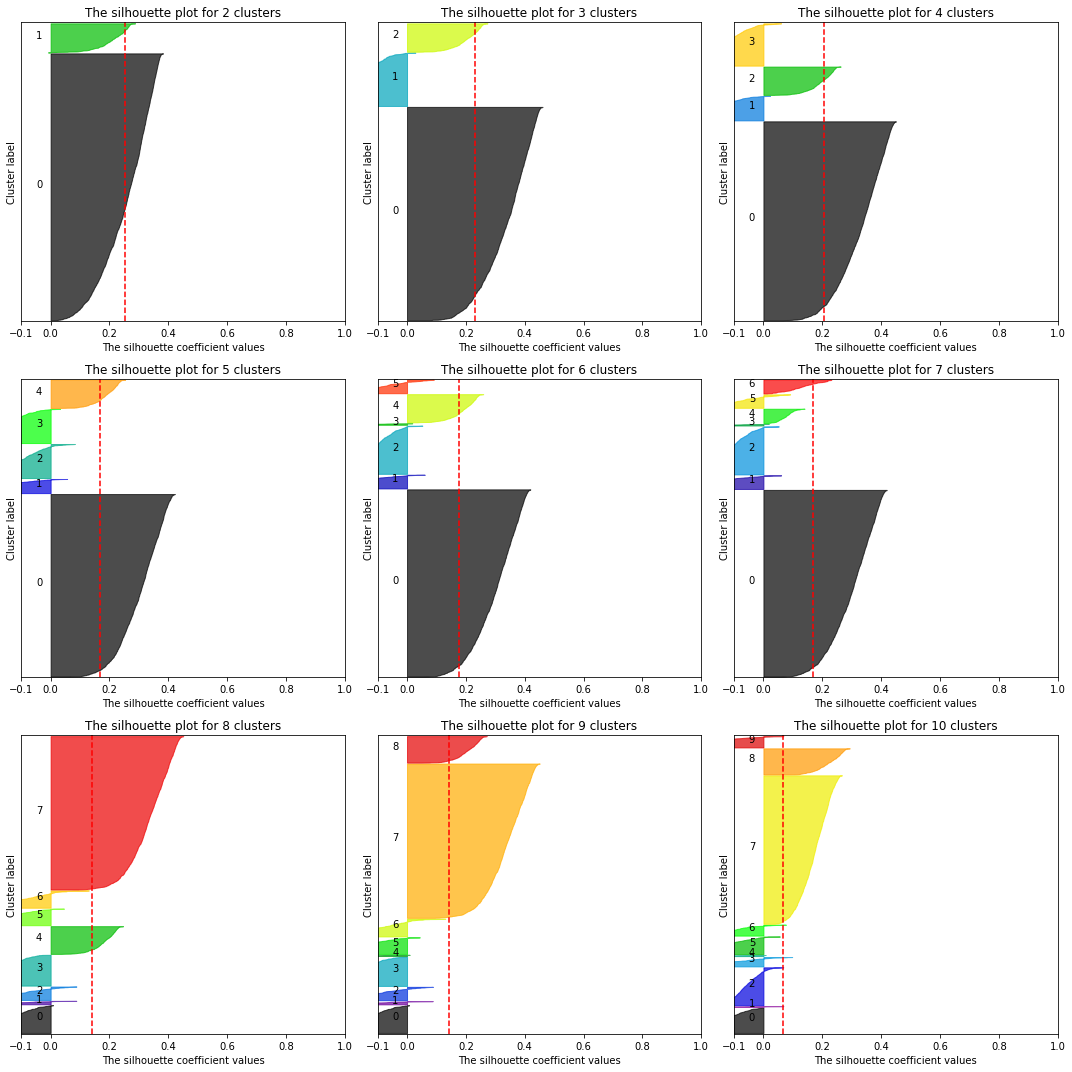

In [8]:
def plot_silhouette(data, n_clusters, ax):
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto").fit(data)
    cluster_labels = clusterer.labels_

    silhouette_avg = silhouette_score(data, cluster_labels)

    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    cluster_samples = {}

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

        cluster_samples[i] = size_cluster_i
    ax.set_title(f"The silhouette plot for {n_clusters} clusters")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    return clusterer.inertia_, silhouette_avg, cluster_samples


fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

range_n_clusters = range(2, 11)

for i, n_clusters in enumerate(range_n_clusters):
    sse, silhouette_avg, cluster_samples = plot_silhouette(data, n_clusters, axs[i])
    print(f"Silhouette score for {n_clusters} clusters: {silhouette_avg}")

plt.tight_layout()
plt.show()

#### <blockquote> It can be seen that most of the divisions have clusters that overlap or almost overlap (we can learn from the graph and the low silhouette score). </blockquote>


##### All the tests done so far did not bring up a definite unequivocal answer, so I built a function that outputs the most frequent words in each cluster. Later we will try to examine in the leading divisions the leading words in each cluster to see if it is clear what characterizes it.

#### <blockquote> Currently the top divisions are 2 (positive silhouette graph) and 4 (low scaled inertia scores).</blockquote>

##### We will extract the leading words for each cluster in the different divisions to examine if there is a logic or theme that characterizes the cluster

In [9]:
def top_words(data, num_words=30):
    word_count_columns = data.columns[1:]
    total_word_counts = data[word_count_columns].sum()
    top_words_df = pd.DataFrame(total_word_counts.nlargest(num_words), columns=['Word Count'])
    return top_words_df

In [10]:
def cluster_and_top_words(data, K=2, num_words=30):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(data)

    # Create a new DataFrame with the original data and cluster labels
    clustered_data = data.copy()
    clustered_data['Cluster'] = kmeans.labels_

    # List to store the DataFrames
    dfs = []

    for i in range(K):
        # Create a new DataFrame for each cluster
        new_df = clustered_data[clustered_data['Cluster'] == i].copy()
        dfs.append(new_df)

    # Dictionary to store the top words for each cluster
    top_words_dict = {}

    for idx, df in enumerate(dfs):
        # Get top words for each cluster
        top_words_df = top_words(df, num_words)
        # Create tuples of word and count
        top_words_tuples = list(zip(top_words_df.index, top_words_df['Word Count']))
        # Store in the dictionary
        top_words_dict[f'Cluster {idx + 1}'] = top_words_tuples

    # Create the final DataFrame
    result_df = pd.DataFrame(top_words_dict)

    return result_df


### K=2

In [11]:
result_df2 = cluster_and_top_words(data, K=2, num_words=30)
result_df2

,Cluster 1,Cluster 2
0,"(november, 3438)","(bush, 6878)"
1,"(poll, 1658)","(kerry, 4488)"
2,"(vote, 1496)","(democrat, 3760)"
3,"(challenge, 1387)","(poll, 3160)"
4,"(democrat, 1093)","(Cluster, 3092)"
5,"(bush, 1061)","(state, 2718)"
6,"(republican, 988)","(republican, 2562)"
7,"(house, 848)","(elect, 2266)"
8,"(senate, 821)","(campaign, 2202)"
9,"(kerry, 805)","(iraq, 2151)"


### Cluster 1:
<blockquote> the first list of words centers around the broader electoral process, evident in the presence of terms like "november," "vote," and "challenge." The unique addition of words such as "labor" and "scoop" suggests a focus on specific events or challenges within the electoral context. Unlike the second list, the first list captures a more general perspective on elections, encompassing a wider array of topics beyond the specific context of the Iraq War.</blockquote>

### Cluster 2:
<blockquote> The second list of words, characterized by terms like "Iraq," "war," and "American," is indicative of a thematic emphasis on the Iraq War and its connection to the broader landscape of American politics. Notably, the inclusion of words such as "Kerry," "Republican," and "democrat" aligns with the timeframe of the 2004 U.S. presidential election, highlighting a narrative that intertwines the political landscape with the ongoing war.</blockquote>


### K=4

In [12]:
result_df4 = cluster_and_top_words(data, K=4, num_words=30)
result_df4

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,"(democrat, 1525)","(bush, 3766)","(november, 3432)","(Cluster, 7008)"
1,"(dean, 1206)","(kerry, 1855)","(poll, 1611)","(bush, 2758)"
2,"(kerry, 844)","(presided, 904)","(vote, 1473)","(kerry, 1804)"
3,"(state, 778)","(poll, 864)","(challenge, 1366)","(democrat, 1801)"
4,"(republican, 733)","(iraq, 802)","(bush, 1022)","(poll, 1740)"
5,"(candidate, 693)","(administration, 645)","(democrat, 958)","(republican, 1423)"
6,"(parties, 691)","(state, 626)","(republican, 919)","(elect, 1377)"
7,"(campaign, 664)","(war, 596)","(house, 829)","(state, 1371)"
8,"(poll, 603)","(democrat, 569)","(kerry, 790)","(iraq, 1301)"
9,"(race, 526)","(time, 561)","(senate, 781)","(war, 1285)"


### Cluster 1:
<blockquote> The first list concentrates on the internal dynamics of the Democratic primary elections during 2004. Words like "Dean," "Kerry," and "primaries" emphasize a detailed exploration of the candidates' strategies within the Democratic Party. The unique focus on terms such as "endorse" and "caucus" suggests a granular examination of candidate endorsements and the caucus system, highlighting the intricate aspects of the Democratic nomination process.</blockquote>

### Cluster 2:
<blockquote> List 2 shifts its focus to the broader political context of the 2004 U.S. presidential election. With keywords like "bush," "kerry," "vote," and "campaign," this list captures the overarching themes of the election process. Notably, terms like "iraq," "war," and "presided" introduce geopolitical elements, indicating a connection between domestic politics and international affairs during a period dominated by the Iraq War.
.</blockquote>

### Cluster 3:
<blockquote> The third list delves into the post-election landscape, with a distinct focus on November and its aftermath. Terms like "november," "vote," and "electoral" highlight discussions around the election results. Additionally, words such as "war," "media," and "economy" reveal ongoing reflections on broader societal issues in the aftermath of the election, suggesting a nuanced exploration of the post-electoral political climate.</blockquote>

### Cluster 4:
<blockquote> List 4 presents a comprehensive blend of themes, encapsulating various aspects of the political landscape. Keywords like "Cluster," "bush," "democrat," and "elect" suggest a broad exploration of political dynamics across both major parties. The inclusion of terms related to the Iraq War and media indicates a sophisticated understanding of the interconnectedness of domestic and international issues. The presence of the term "Cluster" introduces a unique aspect, potentially pointing to a distinct analytical or technical focus within the articles.</blockquote>

## Conclusion:
#### <blockquote>After a detailed examination of the silhouette and thorough investigation of the SSE (scaled inertia), I considered two possible approaches to clustering—either with 2 clusters or 4 clusters. While the 4-cluster division yielded an optimal scaled inertia, concerns arose during the silhouette test regarding potential overlapping clusters. Furthermore, upon examining the leading words in each cluster for the 4-cluster division, the conclusions regarding the subject that characterizes each cluster were not unequivocal. As a result, **I opted to explore the division into 2 clusters due to the clearer and more coherent patterns observed in this approach.** </blockquote>


##### Exporting the clusters to 2 separate files, I chose to export the clusters only after choosing the optimal division and therefore I also researched the issues that characterize each cluster before exporting.

In [13]:
def export_clusters_to_csv(data, output_path='cluster_', num_clusters=2):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42,n_init="auto")
    kmeans.fit(data)

    # Add cluster labels to the original data
    data_with_labels = data.copy()
    data_with_labels['Cluster'] = kmeans.labels_

    # Export separate CSV files for each cluster
    for cluster_label in range(num_clusters):
        cluster_data = data_with_labels[data_with_labels['Cluster'] == cluster_label]
        output_file_path = f"{output_path}cluster_{cluster_label}.csv"
        cluster_data.to_csv(output_file_path, index=False)
        print(f"Cluster {cluster_label} data exported to {output_file_path}")

export_clusters_to_csv(data)

Cluster 0 data exported to cluster_cluster_0.csv
Cluster 1 data exported to cluster_cluster_1.csv


## Hierarchical clustering - agglomerative_clustering

##### The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together.

<blockquote> Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.</blockquote>

<blockquote> Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.</blockquote>

<blockquote> Average linkage minimizes the average of the distances between all observations of pairs of clusters.</blockquote>

<blockquote> Single linkage minimizes the distance between the closest observations of pairs of clusters.</blockquote>

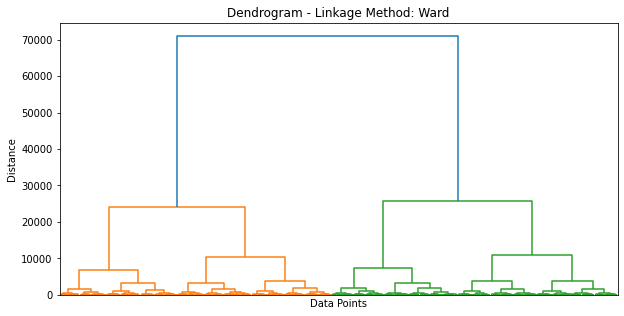

C:\Users\amitf\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster labels using Ward linkage:
[1920 2216 2170 ...    5    2    0]



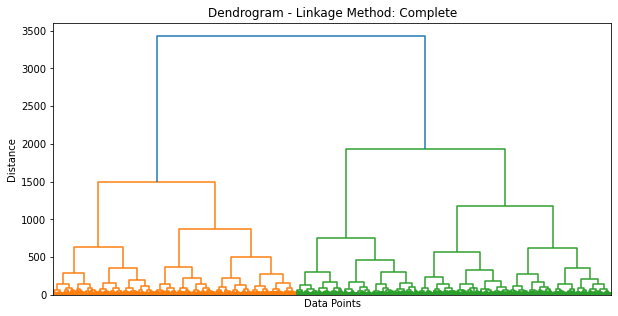

C:\Users\amitf\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster labels using Complete linkage:
[3133 2246 2112 ...    2    1    0]



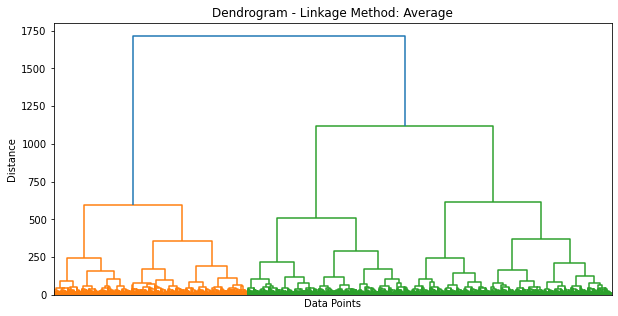

C:\Users\amitf\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster labels using Average linkage:
[3409 2013 1901 ...    2    1    0]



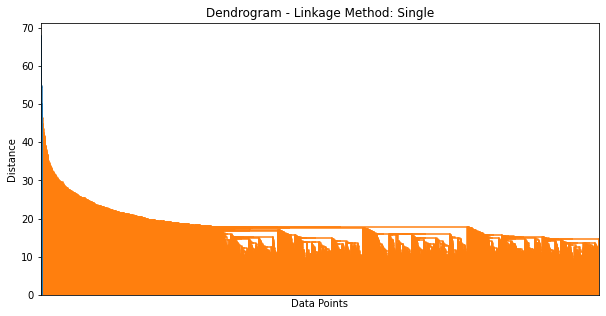

C:\Users\amitf\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster labels using Single linkage:
[3093 1866 2509 ...    4    1    0]



In [4]:
def compare_agglomerative_clustering(data_frame):
    data_array = data_frame.values
    linkage_methods = ['ward', 'complete', 'average', 'single']

    for method in linkage_methods:
        Z = linkage(data_array, method)

        plt.figure(figsize=(10, 5))
        dendrogram(Z, labels=data_frame.index, orientation='top', leaf_rotation=90, leaf_font_size=8)
        plt.title(f'Dendrogram - Linkage Method: {method.capitalize()}')
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-axis tick labels
        plt.show()
        
        cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage=method, distance_threshold=0)
        cluster_labels = cluster.fit_predict(data_array)

        print(f'Cluster labels using {method.capitalize()} linkage:\n{cluster_labels}\n{"="*40}\n')

compare_agglomerative_clustering(data)


## conclusions


<blockquote> single - The algorithm is sensitive to small differences between data points, leading to the formation of numerous clusters. It might capture subtle patterns in the data, but it can also be influenced by noise. </blockquote>

<blockquote> The other methods divide the clusters with relatively clear boundaries, it can be seen that there is a separation in the data, it could be that the methods are less sensitive to noise than the single </blockquote>